In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import sys
import gzip

from yahist import Hist2D

In [3]:
# NOAA hourly data for SBA airport
# https://tgftp.nws.noaa.gov/weather/current/KSBA.html
# downloadable json:
if not os.path.exists("ksba.json.gz"):
    !curl -L "http://erddap.cencoos.org/erddap/tabledap/gov_noaa_nws_ksba.json?time%2Clatitude%2Clongitude%2Cz%2Cair_temperature%2Cair_pressure%2Cdew_point_temperature%2Crelative_humidity%2Cwind_speed%2Cwind_from_direction%2Cstation&time%3E=2000-11-25T00%3A00%3A00Z&time%3C=2019-12-02T14%3A53%3A00Z" | gzip > ksba.json.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4333k    0 4333k    0     0  1238k      0 --:--:--  0:00:03 --:--:-- 1238k


In [4]:
table = json.load(gzip.open("ksba.json.gz"))["table"]
units = table["columnUnits"]
columns = table["columnNames"]
rows = table["rows"]

In [5]:
dfc = pd.DataFrame(rows,columns=columns)
dfc["time"] = pd.to_datetime(dfc["time"])
dfc = dfc.drop(["station","dew_point_temperature","latitude","longitude"],axis=1)
dfc = dfc.set_index("time")
dfc = dfc.sort_index()
dfc["has_wind"] = dfc["wind_speed"] > 0
dfc["hour"] = dfc.index.hour

# good time to bike (from home) TO campus, or FROM campus
dfc["bike_to"] = dfc.eval("not has_wind or (225 <= wind_from_direction <= 315)")
dfc["bike_from"] = dfc.eval("not has_wind or (45 <= wind_from_direction <= 135)")
# x component (east-west), positive if wind pointing east
dfc["vxto"] = -dfc["wind_speed"]*np.cos((90-dfc["wind_from_direction"])*np.pi/180)

/Users/namin/Library/Python/3.7/lib/python/site-packages/pandas/core/generic.py:457: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/Users/namin/Library/Python/3.7/lib/python/site-packages/pandas/core/generic.py:465: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


In [6]:
dfc.index.min()

Timestamp('2015-05-05 12:53:00+0000', tz='UTC')

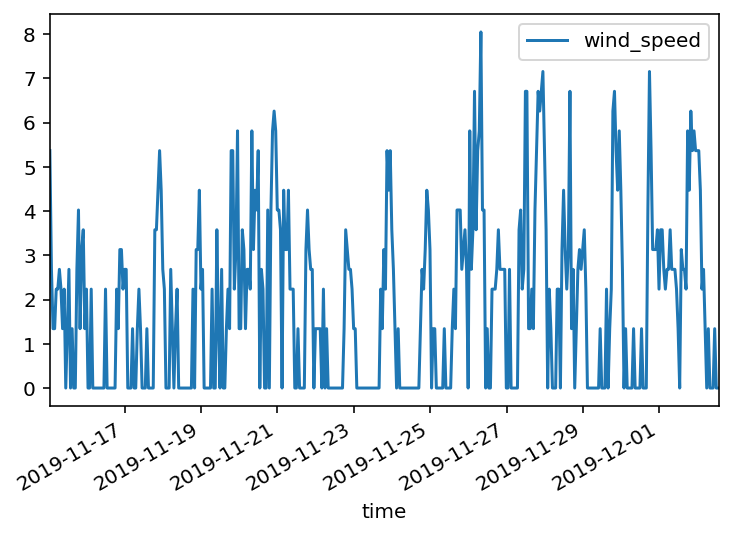

In [7]:
dfc.loc["2019-11-15":,["wind_speed"]].plot()

<ErrorbarContainer object of 3 artists>

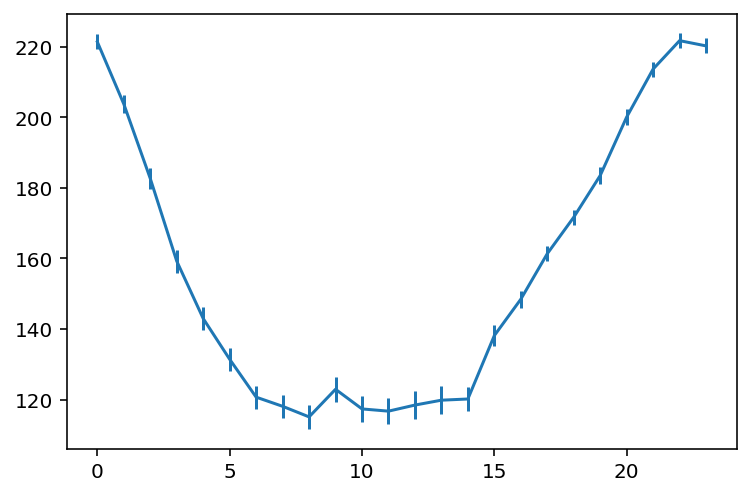

In [8]:
df = dfc.query("has_wind")
group = df.groupby(df.index.hour)["wind_from_direction"]
errs = group.std()/group.count()**0.5
vals = group.mean()
plt.errorbar(vals.index, vals, yerr=errs)

In [9]:
h = Hist2D(
    np.c_[
        df["hour"],
        df["wind_from_direction"],
    ],
    bins=[np.arange(25)-0.5, np.linspace(0,360,360//45+1)]
)
h

[[55.000 ± 7.416   82.000 ± 9.055   88.000 ± 9.381   104.000 ± 10.198
  101.000 ± 10.050   98.000 ± 9.899   98.000 ± 9.899   104.000 ± 10.198
  110.000 ± 10.488   89.000 ± 9.434   110.000 ± 10.488   108.000 ± 10.392
  113.000 ± 10.630   88.000 ± 9.381   94.000 ± 9.695   95.000 ± 9.747
  119.000 ± 10.909   141.000 ± 11.874   159.000 ± 12.610
  166.000 ± 12.884   126.000 ± 11.225   95.000 ± 9.747   66.000 ± 8.124
  75.000 ± 8.660]
 [8.000 ± 2.828   19.000 ± 4.359   51.000 ± 7.141   72.000 ± 8.485
  96.000 ± 9.798   110.000 ± 10.488   132.000 ± 11.489   145.000 ± 12.042
  156.000 ± 12.490   146.000 ± 12.083   161.000 ± 12.689
  165.000 ± 12.845   157.000 ± 12.530   156.000 ± 12.490
  122.000 ± 11.045   75.000 ± 8.660   31.000 ± 5.568   8.000 ± 2.828
  3.000 ± 1.732   2.000 ± 1.414   3.000 ± 1.732   5.000 ± 2.236
  6.000 ± 2.449   3.000 ± 1.732]
 [35.000 ± 5.916   57.000 ± 7.550   82.000 ± 9.055   139.000 ± 11.790
  210.000 ± 14.491   250.000 ± 15.811   293.000 ± 17.117
  256.000 ± 16.000   236.000 ± 15.362   214.000 ± 14.629
  186.000 ± 13.638   171.000 ± 13.077   156.000 ± 12.490
  168.000 ± 12.961   162.000 ± 12.728   126.000 ± 11.225   88.000 ± 9.381
  45.000 ± 6.708   26.000 ± 5.099   14.000 ± 3.742   16.000 ± 4.000
  18.000 ± 4.243   25.000 ± 5.000   32.000 ± 5.657]
 [201.000 ± 14.177   232.000 ± 15.232   234.000 ± 15.297
  229.000 ± 15.133   189.000 ± 13.748   145.000 ± 12.042
  101.000 ± 10.050   89.000 ± 9.434   98.000 ± 9.899   83.000 ± 9.110
  72.000 ± 8.485   74.000 ± 8.602   65.000 ± 8.062   60.000 ± 7.746
  136.000 ± 11.662   261.000 ± 16.155   350.000 ± 18.708
  378.000 ± 19.442   286.000 ± 16.912   203.000 ± 14.248
  158.000 ± 12.570   157.000 ± 12.530   160.000 ± 12.649
  175.000 ± 13.229]
 [93.000 ± 9.644   90.000 ± 9.487   81.000 ± 9.000   59.000 ± 7.681
  44.000 ± 6.633   41.000 ± 6.403   27.000 ± 5.196   35.000 ± 5.916
  30.000 ± 5.477   39.000 ± 6.245   22.000 ± 4.690   34.000 ± 5.831
  27.000 ± 5.196   24.000 ± 4.899   33.000 ± 5.745   116.000 ± 10.770
  243.000 ± 15.588   350.000 ± 18.708   351.000 ± 18.735
  292.000 ± 17.088   219.000 ± 14.799   135.000 ± 11.619
  106.000 ± 10.296   97.000 ± 9.849]
 [142.000 ± 11.916   98.000 ± 9.899   47.000 ± 6.856   30.000 ± 5.477
  24.000 ± 4.899   21.000 ± 4.583   20.000 ± 4.472   23.000 ± 4.796
  7.000 ± 2.646   11.000 ± 3.317   14.000 ± 3.742   17.000 ± 4.123
  12.000 ± 3.464   11.000 ± 3.317   22.000 ± 4.690   50.000 ± 7.071
  108.000 ± 10.392   195.000 ± 13.964   294.000 ± 17.146
  350.000 ± 18.708   370.000 ± 19.235   317.000 ± 17.804
  248.000 ± 15.748   196.000 ± 14.000]
 [687.000 ± 26.211   522.000 ± 22.847   339.000 ± 18.412
  215.000 ± 14.663   142.000 ± 11.916   136.000 ± 11.662   96.000 ± 9.798
  78.000 ± 8.832   85.000 ± 9.220   82.000 ± 9.055   90.000 ± 9.487
  71.000 ± 8.426   81.000 ± 9.000   82.000 ± 9.055   76.000 ± 8.718
  77.000 ± 8.775   79.000 ± 8.888   121.000 ± 11.000   180.000 ± 13.416
  286.000 ± 16.912   415.000 ± 20.372   564.000 ± 23.749
  666.000 ± 25.807   705.000 ± 26.552]
 [59.000 ± 7.681   69.000 ± 8.307   79.000 ± 8.888   83.000 ± 9.110
  86.000 ± 9.274   51.000 ± 7.141   58.000 ± 7.616   61.000 ± 7.810
  58.000 ± 7.616   67.000 ± 8.185   59.000 ± 7.681   64.000 ± 8.000
  66.000 ± 8.124   58.000 ± 7.616   39.000 ± 6.245   43.000 ± 6.557
  31.000 ± 5.568   31.000 ± 5.568   28.000 ± 5.292   28.000 ± 5.292
  34.000 ± 5.831   49.000 ± 7.000   47.000 ± 6.856   43.000 ± 6.557]]

Text(0.5, 1.0, 'Wind direction')

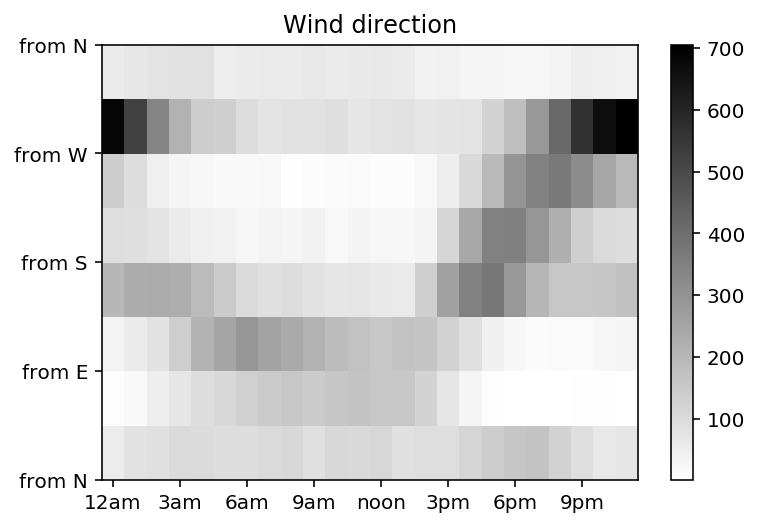

In [10]:
fig, ax = plt.subplots()
h.plot(ax=ax,cmap="binary")
plt.yticks([0,90,180,270,360],["from N","from E","from S","from W","from N"])
plt.xticks([0,3,6,9,12,15,18,21],["12am","3am","6am","9am","noon","3pm","6pm","9pm"])
ax.set_title("Wind direction")

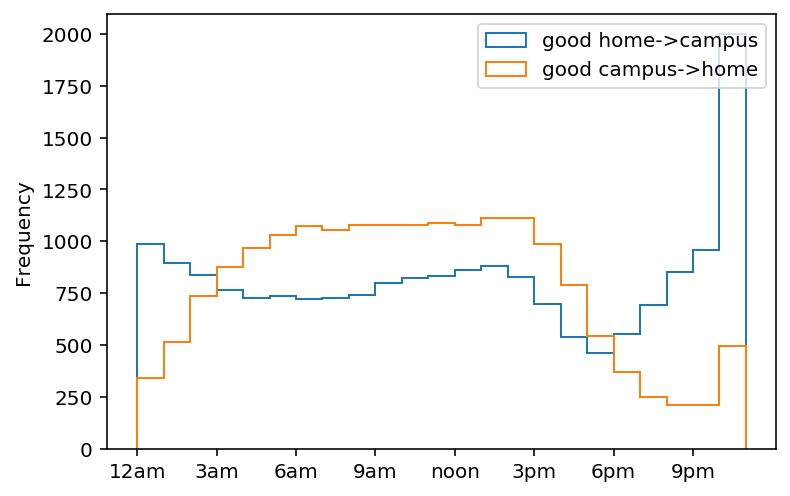

In [11]:
fig, ax = plt.subplots()
dfc.query("bike_to")["hour"].plot.hist(ax=ax,bins=np.arange(24),label="good home->campus",histtype="step")
dfc.query("bike_from")["hour"].plot.hist(ax=ax,bins=np.arange(24),label="good campus->home",histtype="step")
plt.xticks([0,3,6,9,12,15,18,21],["12am","3am","6am","9am","noon","3pm","6pm","9pm"]);
ax.legend()

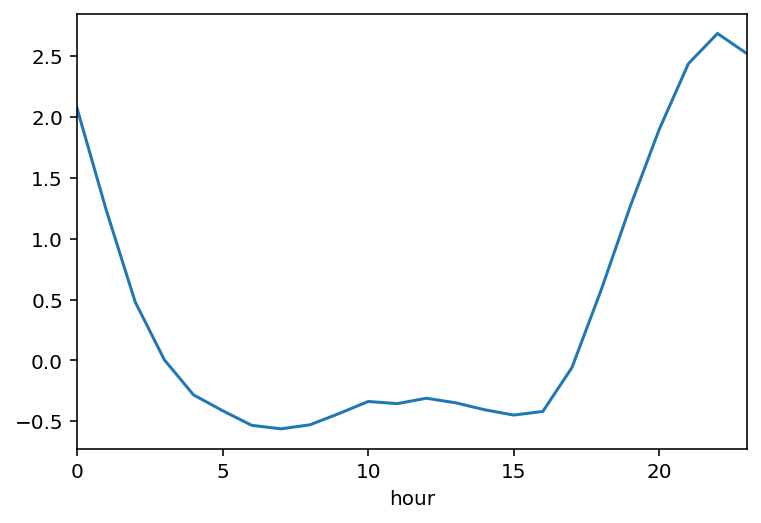

In [12]:
dfc.groupby("hour")["vxto"].mean().plot()